## Queensland Crashes Data Analysis

**Dataset:** = https://www.data.qld.gov.au/dataset/crash-data-from-queensland-roads

-----------

#### Overview:

Information on location and characteristics of crashes in Queensland for all reported Road Traffic Crashes occurred from 1 January 2001 to 31 Dec 2024.

In [1]:
#%matplotlib ipympl
%matplotlib inline
#%matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json as js
import requests as rq
import urllib.request
import ipympl
import folium
from IPython.display import IFrame
%matplotlib inline

In [2]:
df = pd.read_csv('_1_crash_locations.csv')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25780\3600421848.py:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('_1_crash_locations.csv')


we need to address to this error before starting the analysis:

In [3]:
data_types = {
    'Crash_Street_Intersecting': str, 
    'State_Road_Name': str
}

df = pd.read_csv(
    '_1_crash_locations.csv', 
    dtype=data_types,
    low_memory=False
)

In [4]:
pd.set_option('display.max_columns', None)
df.sample(5)

,Crash_Ref_Number,Crash_Severity,Crash_Year,Crash_Month,Crash_Day_Of_Week,Crash_Hour,Crash_Nature,Crash_Type,Crash_Longitude,Crash_Latitude,Crash_Street,Crash_Street_Intersecting,State_Road_Name,Loc_Suburb,Loc_Local_Government_Area,Loc_Post_Code,Loc_Police_Division,Loc_Police_District,Loc_Police_Region,Loc_Queensland_Transport_Region,Loc_Main_Roads_Region,Loc_ABS_Statistical_Area_2,Loc_ABS_Statistical_Area_3,Loc_ABS_Statistical_Area_4,Loc_ABS_Remoteness,Loc_State_Electorate,Loc_Federal_Electorate,Crash_Controlling_Authority,Crash_Roadway_Feature,Crash_Traffic_Control,Crash_Speed_Limit,Crash_Road_Surface_Condition,Crash_Atmospheric_Condition,Crash_Lighting_Condition,Crash_Road_Horiz_Align,Crash_Road_Vert_Align,Crash_DCA_Code,Crash_DCA_Description,Crash_DCA_Group_Description,DCA_Key_Approach_Dir,Count_Casualty_Fatality,Count_Casualty_Hospitalised,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_Total,Count_Unit_Car,Count_Unit_Motorcycle_Moped,Count_Unit_Truck,Count_Unit_Bus,Count_Unit_Bicycle,Count_Unit_Pedestrian,Count_Unit_Other
39604,39605,Hospitalisation,2006,December,Sunday,1,Angle,Multi-Vehicle,153.411884,-28.011370,Ashmore Rd,Southport - Burleigh Rd,Southport - Burleigh Road,Bundall,Gold Coast City,4217,Broadbeach,Gold Coast,South Eastern,SEQ South,South Coast,Bundall,Surfers Paradise,Gold Coast,Major Cities,Surfers Paradise,Moncrieff,State-controlled,Intersection - Multiple Road,Operating traffic lights,60 km/h,Sealed - Wet,Raining,Darkness - Lighted,Straight,Level,101,Vehs Adjacent Approach: Thru-Thru,01: Intersection: Adjacent Approach,N,0,1,0,0,1,2,0,0,0,0,0,0
354919,354920,Property damage only,2009,November,Saturday,11,Overturned,Single Vehicle,152.748465,-28.326213,Mt Lindesay Hwy,NaN,Mount Lindesay Highway (Beaudesert - Border),Mount Lindesay,Scenic Rim Region,4287,Rathdowney,Logan,South Eastern,SEQ South,South Coast,Beaudesert,Beaudesert,Logan - Beaudesert,Inner Regional,Scenic Rim,Wright,State-controlled,No Roadway Feature,No traffic control,100 - 110 km/h,Sealed - Wet,Raining,Daylight,Curved - view obscured,Grade,802,Off Path-Curve: Off Cway Left Bend,18: Off Carriageway on Curve,S,0,0,0,0,0,1,0,0,0,0,0,0
147987,147988,Property damage only,2006,June,Friday,16,Angle,Multi-Vehicle,148.581285,-28.038052,Alfred St,Carnarvon Hwy,Carnarvon Highway (Mungindi - St George),St George,Balonne Shire,4487,Saint George,South West,Southern,Southern,Southern Queensland,Balonne,Darling Downs (west) - Maranoa,Darling Downs - Maranoa,Remote,Warrego,Maranoa,State-controlled,Intersection - Cross,Stop sign,60 km/h,Sealed - Wet,Clear,Daylight,Straight,Level,101,Vehs Adjacent Approach: Thru-Thru,01: Intersection: Adjacent Approach,N,0,0,0,0,0,2,0,0,0,0,0,0
152778,152779,Medical treatment,2022,December,Wednesday,8,Rear-end,Multi-Vehicle,153.088844,-27.567883,Logan Rd,NaN,Logan Sub-Arterial Road,Upper Mount Gravatt,Brisbane City,4122,Upper Mount Gravatt,South Brisbane,Brisbane,SEQ South,Metropolitan,Upper Mount Gravatt,Mt Gravatt,Brisbane - South,Major Cities,Mansfield,Bonner,State-controlled,No Roadway Feature,No traffic control,70 km/h,Sealed - Dry,Clear,Daylight,Curved - view open,Grade,301,Vehs Same Direction: Rear End,04: Rear-end,W,0,0,2,0,2,2,0,1,0,0,0,0
105028,105029,Medical treatment,2004,June,Thursday,11,Angle,Multi-Vehicle,153.057158,-27.667991,Mayfair Dr,NaN,NaN,Browns Plains,Logan City,4118,Browns Plains,Logan,South Eastern,SEQ South,South Coast,Browns Plains,Browns Plains,Logan - Beaudesert,Major Cities,Woodridge,Rankin,Locally-controlled,No Roadway Feature,No traffic control,0 - 50 km/h,Sealed - Dry,Clear,Daylight,Straight,Level,207,Vehs Opposite Approach: U-Turn,07: U-turn,W,0,0,1,0,1,2,0,0,0,0,0,0


Removing less useful columns:

In [5]:
df1 = df.copy()

columns_to_drop = [
    # 1. Data Leakage --> keep them for EDA and remove them for model development
    
    #'Count_Casualty_Fatality',
    #'Count_Casualty_Hospitalised',
    #'Count_Casualty_MedicallyTreated',
    #'Count_Casualty_MinorInjury',
    #'Count_Casualty_Total',
    
    # 2. Irrelevant IDs / High Cardinality
    #'Crash_Ref_Number',  --> remove it for model development
    
    'Crash_Street_Intersecting',
    'State_Road_Name',
    'Crash_DCA_Code',
    'Crash_DCA_Description',

    # 3. Redundant Location Features
    'Loc_Suburb',
    'Loc_Local_Government_Area',
    'Loc_Post_Code',
    'Loc_Police_Division',
    'Loc_Police_District',
    'Loc_Police_Region',
    'Loc_Queensland_Transport_Region',
    'Loc_Main_Roads_Region',
    'Loc_ABS_Statistical_Area_2',
    'Loc_ABS_Statistical_Area_3',
    'Loc_ABS_Statistical_Area_4',
    'Loc_State_Electorate',
    'Loc_Federal_Electorate'
]

df = df.drop(columns_to_drop, axis=1)

In [6]:
print('unique values in categorical columns: \n')
for i in df.select_dtypes(include='object'):
    print(i, ':', df[str(i)].unique(), df[str(i)].nunique(), '\n\n')

unique values in categorical columns: 

Crash_Severity : ['Medical treatment' 'Property damage only' 'Hospitalisation'
 'Minor injury' 'Fatal'] 5 


Crash_Month : ['November' 'August' 'May' 'June' 'April' 'September' 'December' 'March'
 'July' 'October' 'January' 'February'] 12 


Crash_Day_Of_Week : ['Saturday' 'Wednesday' 'Sunday' 'Monday' 'Friday' 'Thursday' 'Tuesday'] 7 


Crash_Nature : ['Hit parked vehicle' 'Rear-end' 'Hit object' 'Hit pedestrian' 'Angle'
 'Hit animal' 'Overturned' 'Sideswipe' 'Head-on'
 'Non-collision - miscellaneous' 'Fall from vehicle'
 'Struck by external load' 'Collision - miscellaneous'
 'Struck by internal load' 'Other'] 15 


Crash_Type : ['Single Vehicle' 'Multi-Vehicle' 'Hit pedestrian' 'Other'] 4 


Crash_Street : ['Boundary St' 'South East Arterial Rd' 'Markeri St' ... 'Rosebank Sq'
 'Houston Rd' 'Pradella Rd'] 23254 


Loc_ABS_Remoteness : ['Major Cities' 'Outer Regional' 'Inner Regional' 'Remote' 'Very Remote'
 'Unknown'] 6 


Crash_Controlling_Auth

### Summary statistics:

In [7]:
# dataset dimensions:

df.shape

(408271, 35)

In [8]:
# short summary of our dataset:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408271 entries, 0 to 408270
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Crash_Ref_Number                 408271 non-null  int64  
 1   Crash_Severity                   408271 non-null  object 
 2   Crash_Year                       408271 non-null  int64  
 3   Crash_Month                      408271 non-null  object 
 4   Crash_Day_Of_Week                408271 non-null  object 
 5   Crash_Hour                       408271 non-null  int64  
 6   Crash_Nature                     408271 non-null  object 
 7   Crash_Type                       408271 non-null  object 
 8   Crash_Longitude                  407673 non-null  float64
 9   Crash_Latitude                   407673 non-null  float64
 10  Crash_Street                     408256 non-null  object 
 11  Loc_ABS_Remoteness               408271 non-null  object 
 12  Cr

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Crash_Ref_Number,408271.0,204136.000000,117857.830214,1.000000,102068.500000,204136.000000,306203.500000,408271.000000
Crash_Year,408271.0,2010.875107,6.920736,2001.000000,2005.000000,2009.000000,2017.000000,2024.000000
Crash_Hour,408271.0,12.795192,5.286709,0.000000,9.000000,13.000000,17.000000,23.000000
Crash_Longitude,407673.0,151.751120,2.565208,137.998204,151.941312,152.987999,153.087983,153.550268
Crash_Latitude,407673.0,-25.833062,3.227712,-29.145815,-27.600604,-27.436078,-25.698881,-9.380213
Count_Casualty_Fatality,408271.0,0.016834,0.142542,0.000000,0.000000,0.000000,0.000000,5.000000
Count_Casualty_Hospitalised,408271.0,0.391855,0.659451,0.000000,0.000000,0.000000,1.000000,22.000000
Count_Casualty_MedicallyTreated,408271.0,0.415812,0.668561,0.000000,0.000000,0.000000,1.000000,29.000000
Count_Casualty_MinorInjury,408271.0,0.223788,0.516818,0.000000,0.000000,0.000000,0.000000,17.000000
Count_Casualty_Total,408271.0,1.048289,0.862228,0.000000,1.000000,1.000000,1.000000,32.000000


In [10]:
### Data Wrangling: Columns contain Null values:

df.isna().sum()

Crash_Ref_Number                      0
Crash_Severity                        0
Crash_Year                            0
Crash_Month                           0
Crash_Day_Of_Week                     0
Crash_Hour                            0
Crash_Nature                          0
Crash_Type                            0
Crash_Longitude                     598
Crash_Latitude                      598
Crash_Street                         15
Loc_ABS_Remoteness                    0
Crash_Controlling_Authority           0
Crash_Roadway_Feature                 0
Crash_Traffic_Control                 0
Crash_Speed_Limit                     3
Crash_Road_Surface_Condition          0
Crash_Atmospheric_Condition           0
Crash_Lighting_Condition              0
Crash_Road_Horiz_Align                0
Crash_Road_Vert_Align                 1
Crash_DCA_Group_Description           0
DCA_Key_Approach_Dir               7523
Count_Casualty_Fatality               0
Count_Casualty_Hospitalised           0


#### How to deal with Nulls?

**Imputing by mean:**

    - Crash_Longitude                    
    - Crash_Latitude                     

**Imputing by mod:**

    - Crash_Road_Vert_Align
    - Crash_Speed_Limit 
    

In [11]:
df['DCA_Key_Approach_Dir'].unique()

array(['E', 'N', 'S', 'W', nan, 'U', 'P'], dtype=object)

In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
df[['DCA_Key_Approach_Dir']] = imputer.fit_transform(df[['DCA_Key_Approach_Dir']])

In [13]:
df['Crash_Longitude'] = df['Crash_Longitude'].replace(np.nan, df['Crash_Longitude'].mean())
df['Crash_Latitude'] = df['Crash_Latitude'].replace(np.nan, df['Crash_Latitude'].mean())

In [14]:
df['Crash_Road_Vert_Align'] = df['Crash_Road_Vert_Align'].replace(np.nan, df['Crash_Road_Vert_Align'].mode()[0])
df['Crash_Speed_Limit'] = df['Crash_Speed_Limit'].replace(np.nan, df['Crash_Speed_Limit'].mode()[0])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408271 entries, 0 to 408270
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Crash_Ref_Number                 408271 non-null  int64  
 1   Crash_Severity                   408271 non-null  object 
 2   Crash_Year                       408271 non-null  int64  
 3   Crash_Month                      408271 non-null  object 
 4   Crash_Day_Of_Week                408271 non-null  object 
 5   Crash_Hour                       408271 non-null  int64  
 6   Crash_Nature                     408271 non-null  object 
 7   Crash_Type                       408271 non-null  object 
 8   Crash_Longitude                  408271 non-null  float64
 9   Crash_Latitude                   408271 non-null  float64
 10  Crash_Street                     408256 non-null  object 
 11  Loc_ABS_Remoteness               408271 non-null  object 
 12  Cr

In [16]:
df[df=='Unknown'].count()

Crash_Ref_Number                     0
Crash_Severity                       0
Crash_Year                           0
Crash_Month                          0
Crash_Day_Of_Week                    0
Crash_Hour                           0
Crash_Nature                         0
Crash_Type                           0
Crash_Longitude                      0
Crash_Latitude                       0
Crash_Street                         0
Loc_ABS_Remoteness                 600
Crash_Controlling_Authority          0
Crash_Roadway_Feature                0
Crash_Traffic_Control                0
Crash_Speed_Limit                    0
Crash_Road_Surface_Condition       318
Crash_Atmospheric_Condition        219
Crash_Lighting_Condition           380
Crash_Road_Horiz_Align               9
Crash_Road_Vert_Align               10
Crash_DCA_Group_Description          0
DCA_Key_Approach_Dir                 0
Count_Casualty_Fatality              0
Count_Casualty_Hospitalised          0
Count_Casualty_MedicallyT

#### Replacing all 'Unkown' values with mode:

In [17]:
df['Loc_ABS_Remoteness'] = df['Loc_ABS_Remoteness'].replace('Unknown', df['Loc_ABS_Remoteness'].mode()[0])
df['Crash_Road_Surface_Condition'] = df['Crash_Road_Surface_Condition'].replace('Unknown', df['Crash_Road_Surface_Condition'].mode()[0])
df['Crash_Atmospheric_Condition'] = df['Crash_Atmospheric_Condition'].replace('Unknown', df['Crash_Atmospheric_Condition'].mode()[0])
df['Crash_Lighting_Condition'] = df['Crash_Lighting_Condition'].replace('Unknown', df['Crash_Lighting_Condition'].mode()[0])
df['Crash_Road_Horiz_Align'] = df['Crash_Road_Horiz_Align'].replace('Unknown', df['Crash_Road_Horiz_Align'].mode()[0])
df['Crash_Road_Vert_Align'] = df['Crash_Road_Vert_Align'].replace('Unknown', df['Crash_Road_Vert_Align'].mode()[0])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408271 entries, 0 to 408270
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Crash_Ref_Number                 408271 non-null  int64  
 1   Crash_Severity                   408271 non-null  object 
 2   Crash_Year                       408271 non-null  int64  
 3   Crash_Month                      408271 non-null  object 
 4   Crash_Day_Of_Week                408271 non-null  object 
 5   Crash_Hour                       408271 non-null  int64  
 6   Crash_Nature                     408271 non-null  object 
 7   Crash_Type                       408271 non-null  object 
 8   Crash_Longitude                  408271 non-null  float64
 9   Crash_Latitude                   408271 non-null  float64
 10  Crash_Street                     408256 non-null  object 
 11  Loc_ABS_Remoteness               408271 non-null  object 
 12  Cr

In [19]:
df[df=='Unknown'].count()

Crash_Ref_Number                   0
Crash_Severity                     0
Crash_Year                         0
Crash_Month                        0
Crash_Day_Of_Week                  0
Crash_Hour                         0
Crash_Nature                       0
Crash_Type                         0
Crash_Longitude                    0
Crash_Latitude                     0
Crash_Street                       0
Loc_ABS_Remoteness                 0
Crash_Controlling_Authority        0
Crash_Roadway_Feature              0
Crash_Traffic_Control              0
Crash_Speed_Limit                  0
Crash_Road_Surface_Condition       0
Crash_Atmospheric_Condition        0
Crash_Lighting_Condition           0
Crash_Road_Horiz_Align             0
Crash_Road_Vert_Align              0
Crash_DCA_Group_Description        0
DCA_Key_Approach_Dir               0
Count_Casualty_Fatality            0
Count_Casualty_Hospitalised        0
Count_Casualty_MedicallyTreated    0
Count_Casualty_MinorInjury         0
C

----------------------
### All good! dive into EDA!
-----------------

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Crash_Ref_Number,408271.0,204136.000000,117857.830214,1.000000,102068.500000,204136.000000,306203.500000,408271.000000
Crash_Year,408271.0,2010.875107,6.920736,2001.000000,2005.000000,2009.000000,2017.000000,2024.000000
Crash_Hour,408271.0,12.795192,5.286709,0.000000,9.000000,13.000000,17.000000,23.000000
Crash_Longitude,408271.0,151.751120,2.563328,137.998204,151.939268,152.987656,153.087839,153.550268
Crash_Latitude,408271.0,-25.833062,3.225347,-29.145815,-27.600350,-27.435333,-25.731498,-9.380213
Count_Casualty_Fatality,408271.0,0.016834,0.142542,0.000000,0.000000,0.000000,0.000000,5.000000
Count_Casualty_Hospitalised,408271.0,0.391855,0.659451,0.000000,0.000000,0.000000,1.000000,22.000000
Count_Casualty_MedicallyTreated,408271.0,0.415812,0.668561,0.000000,0.000000,0.000000,1.000000,29.000000
Count_Casualty_MinorInjury,408271.0,0.223788,0.516818,0.000000,0.000000,0.000000,0.000000,17.000000
Count_Casualty_Total,408271.0,1.048289,0.862228,0.000000,1.000000,1.000000,1.000000,32.000000


In [21]:
# How many accidents are recorded in the dataset?

df['Crash_Ref_Number'].count()

408271

In [22]:
# number of people injured in the accident?

df['Count_Casualty_Total'].sum()

427986

In [23]:
# number of vehicles involved?

(df['Count_Unit_Car'] + df['Count_Unit_Motorcycle_Moped'] + df['Count_Unit_Truck'] + df['Count_Unit_Bus']).sum()

711800

In [26]:
# a short report of classes for each features by counting classes

for i in df.select_dtypes(include='object'):
    print(i, ':', df[str(i)].value_counts(), '\n\n')

Crash_Severity : Crash_Severity
Hospitalisation         129821
Medical treatment       127856
Property damage only     87432
Minor injury             56900
Fatal                     6262
Name: count, dtype: int64 


Crash_Month : Crash_Month
August       36368
July         35951
May          35702
March        35219
October      35119
June         34681
November     34403
September    33771
April        32943
December     32841
February     31477
January      29796
Name: count, dtype: int64 


Crash_Day_Of_Week : Crash_Day_Of_Week
Friday       68671
Thursday     62420
Wednesday    59889
Tuesday      58242
Saturday     57201
Monday       55283
Sunday       46565
Name: count, dtype: int64 


Crash_Nature : Crash_Nature
Angle                            121612
Rear-end                         101093
Hit object                        87433
Overturned                        20107
Sideswipe                         19633
Hit pedestrian                    16568
Hit parked vehicle               

In [27]:
df['Crash_Year'].value_counts().sort_index()

Crash_Year
2001    22023
2002    22316
2003    22393
2004    23441
2005    23077
2006    22454
2007    22847
2008    23525
2009    22942
2010    22537
2011    12689
2012    12750
2013    12739
2014    12654
2015    12159
2016    12553
2017    12736
2018    12958
2019    12965
2020    12147
2021    13477
2022    13021
2023    13610
2024    14258
Name: count, dtype: int64

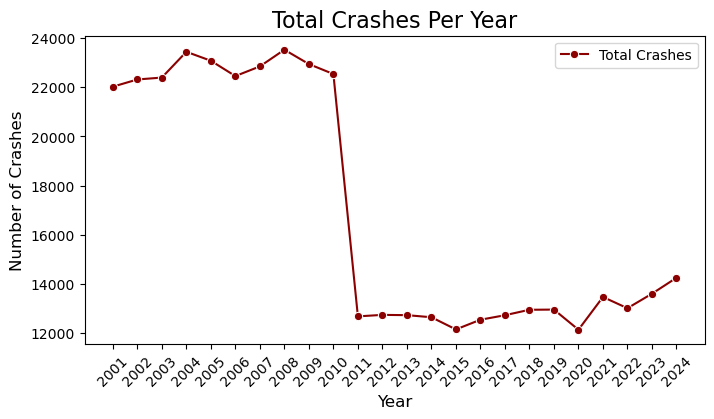

In [34]:
# total crashes per year

crashes_per_year = df[['Crash_Ref_Number', 'Crash_Year']].groupby(['Crash_Year']).count()

plt.figure(figsize=(8,4))
sns.lineplot(
    data=crashes_per_year, 
    x=crashes_per_year.index,
    y='Crash_Ref_Number', 
    label='Total Crashes',
    color='darkred',
    marker='o'
)

plt.title('Total Crashes Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.xticks(crashes_per_year.index.unique(), rotation=45)
plt.legend()
plt.show()

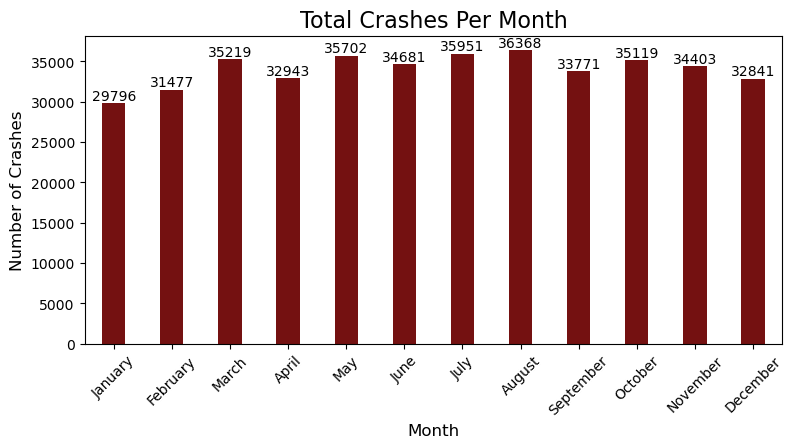

In [29]:
# total crashes per month

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]

crash_hour = df.groupby('Crash_Month')['Crash_Ref_Number'].count()
crash_hour_sorted = crash_hour.reindex(month_order)

w=crash_hour_sorted.index
z=crash_hour_sorted.values
plt.figure(figsize=(9,4))
ax = sns.barplot(x=w,y=z, color = '#850000', gap=1.5, legend='full')
ax.bar_label(ax.containers[0], fontsize=10)
#plt.plot(w, z, color='#900000')
plt.xticks(w, rotation=45)
plt.title('Total Crashes Per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.show()

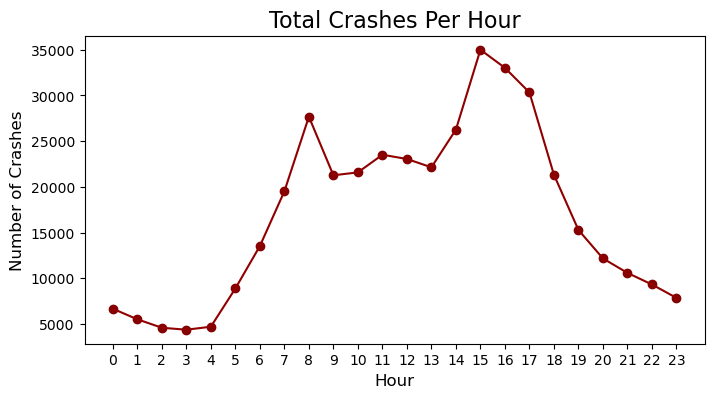

In [30]:
# total crashes per hour

crash_hour = df.groupby('Crash_Hour')['Crash_Ref_Number'].count()

w=crash_hour.index
z=crash_hour.values
plt.figure(figsize=(8,4))
plt.scatter(x=w,y=z, color = '#850000')
plt.plot(w, z, linestyle='-', color='#900000')
plt.xticks(w)
plt.title('Total Crashes Per Hour', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.show()

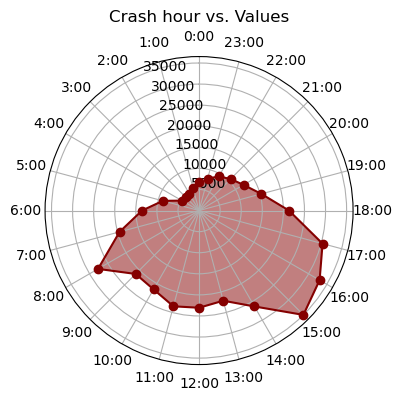

In [31]:
# total crashes per hour - another visualization

plt.figure(figsize=(4, 4))


# Create a polar plot
ax = plt.subplot(111, projection='polar')

# Convert hours to radians
hours_in_radians = np.deg2rad((crash_hour.index) * 360 / 24)

# Plot values
ax.plot(hours_in_radians, crash_hour.values, marker='o', linestyle='-', color='#850000')

# Set radial axis labels to show hours
ax.set_xticks(hours_in_radians)
ax.set_xticklabels([str(hour) + ':00' for hour in crash_hour.index])
ax.set_theta_offset(np.pi/2)

# Fill the space between the data points
ax.fill(hours_in_radians, crash_hour.values, '#850000', alpha=0.5)  # Adjust alpha for transparency ---> #850000 is dark red.

# Add a title
ax.set_title('Crash hour vs. Values')

# Show the polar plot
plt.show()

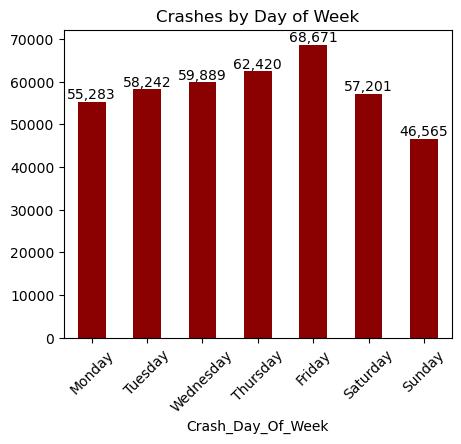

In [32]:
day_counts = df.groupby('Crash_Day_Of_Week')['Crash_Ref_Number'].count()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(day_order)

plt.figure(figsize=(5,4))
ax = day_counts.plot(kind='bar', title='Crashes by Day of Week', color='darkred')
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:,.0f}')
plt.xticks(rotation=45)
plt.show()

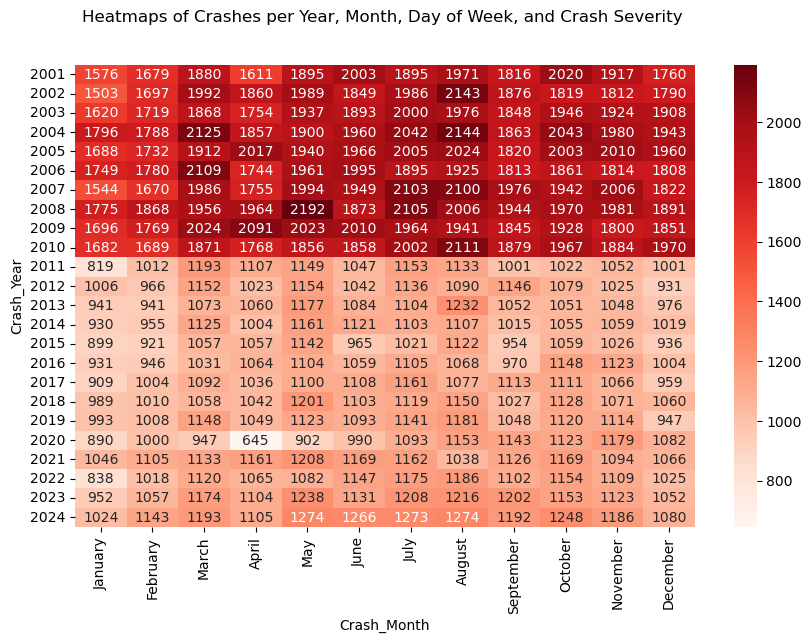

In [33]:
# heat map of crashes per year and mmonth

pivot_table_yearly_crashes = df.pivot_table(index='Crash_Year', columns= 'Crash_Month', values='Crash_Ref_Number', aggfunc='count')
pivot_table_yearly_crashes = pivot_table_yearly_crashes.reindex(columns=month_order)

plt.figure(figsize=(10, 6))
cmap = sns.color_palette("Reds", as_cmap=True)
sns.heatmap(pivot_table_yearly_crashes, cmap=cmap, annot=True, fmt='.0f', cbar=True, linecolor='black')
plt.title("Heatmaps of Crashes per Year, Month, Day of Week, and Crash Severity \n\n")
plt.show()

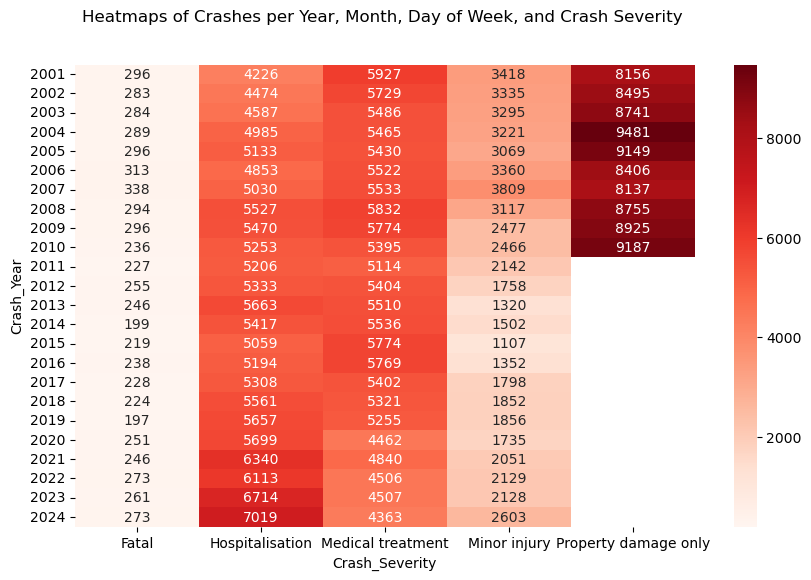

In [74]:
# heat map of crashes severity per year 

pivot_table_yearly_severity = df.pivot_table(index='Crash_Year', columns= 'Crash_Severity', values='Crash_Ref_Number', aggfunc='count')

plt.figure(figsize=(10, 6))
cmap = sns.color_palette("Reds", as_cmap=True)
sns.heatmap(pivot_table_yearly_severity, cmap=cmap, annot=True, fmt='.0f', cbar=True, linecolor='black')
plt.title("Heatmaps of Crashes per Year, Month, Day of Week, and Crash Severity \n\n")
plt.show()

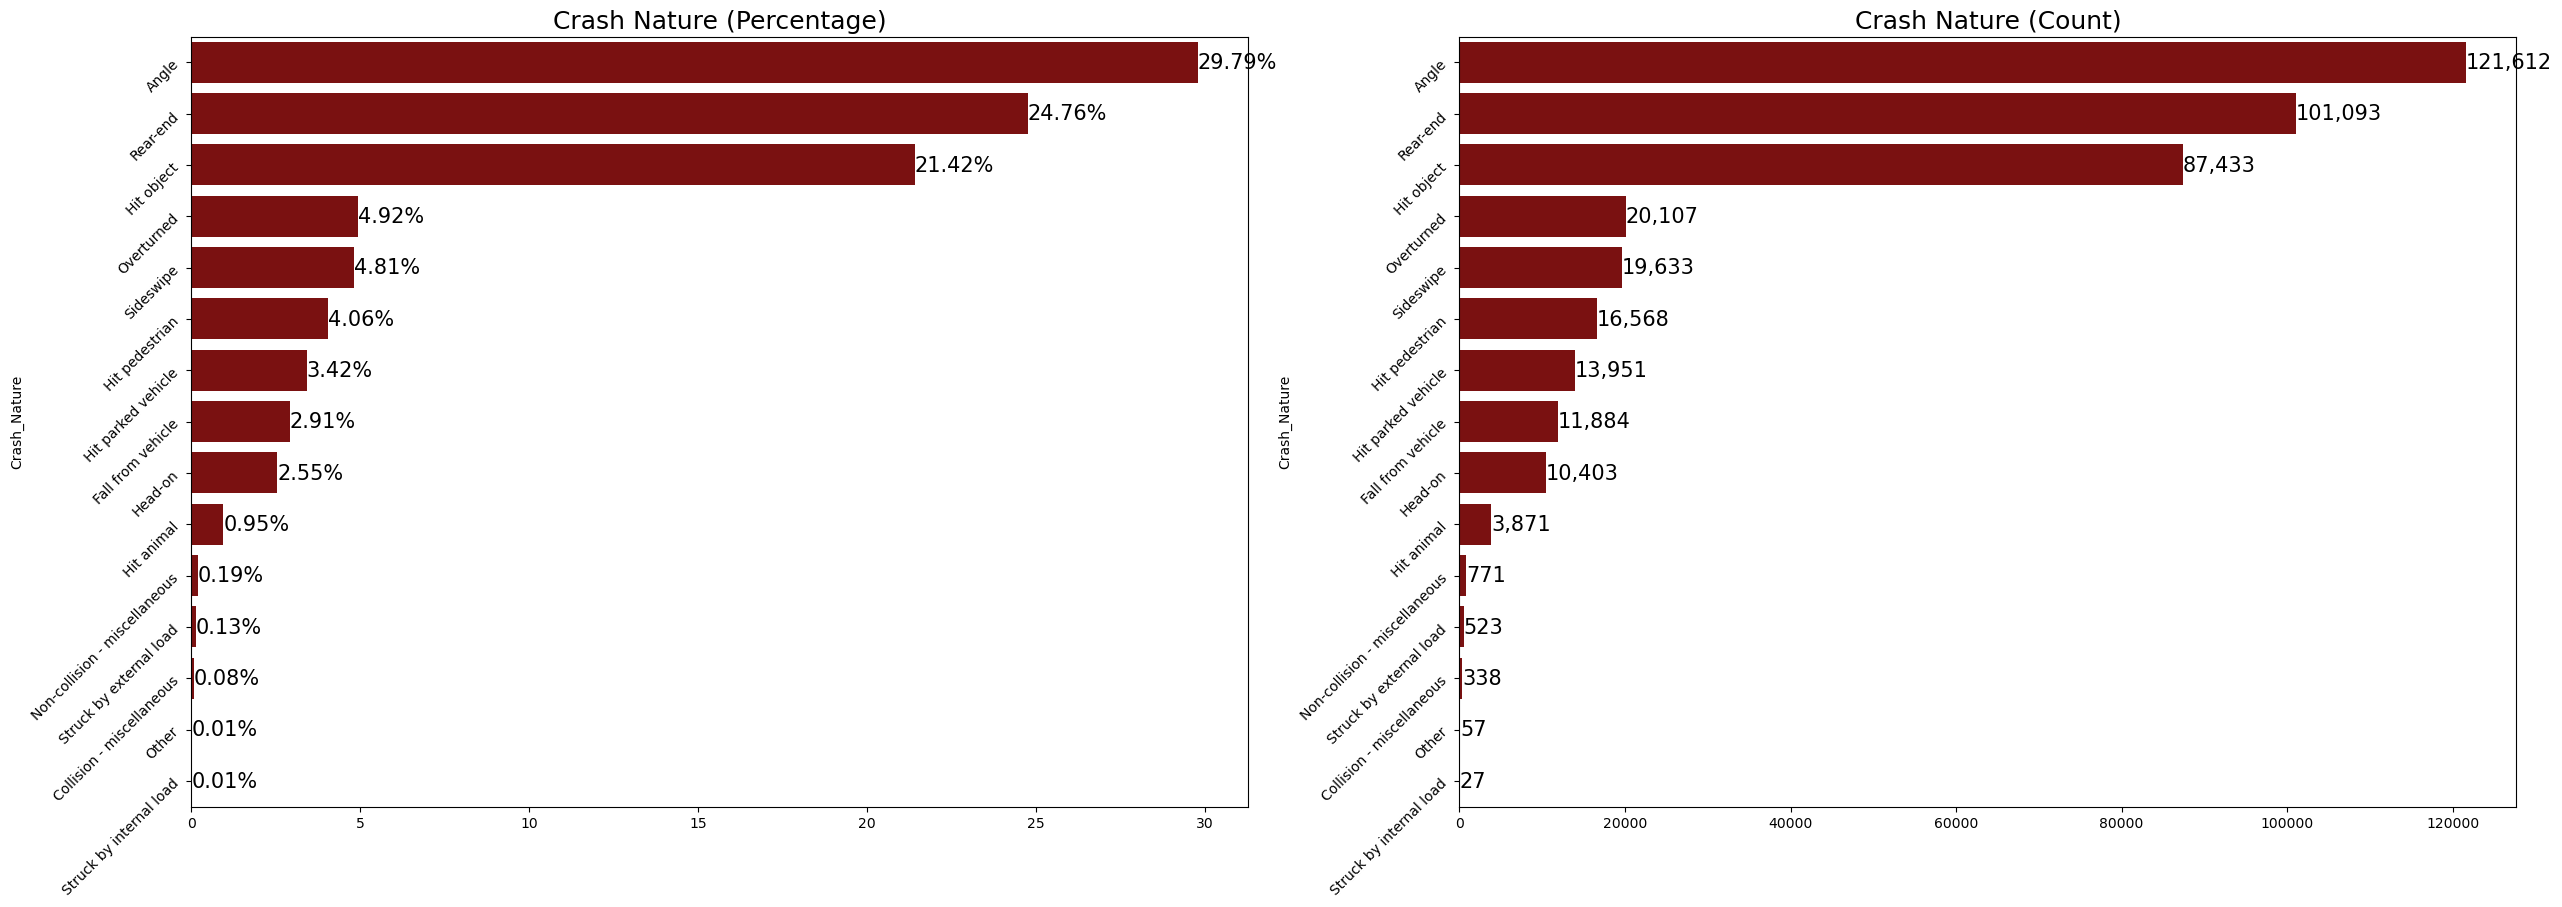

In [35]:
# crash nature

Crash_Nature = df['Crash_Nature'].value_counts()

plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.title('Crash Nature (Percentage)', fontsize=18)
ax = sns.barplot(y=Crash_Nature.index, x=(100*(Crash_Nature.values)/(Crash_Nature.values.sum())), color='darkred')
plt.yticks(rotation=45)
ax.bar_label(ax.containers[0], fontsize=15, fmt='%.2f%%')

plt.subplot(1, 2, 2)
plt.title('Crash Nature (Count)', fontsize=18)
ax = sns.barplot(y=Crash_Nature.index, x=Crash_Nature.values, color='darkred')
ax.bar_label(ax.containers[0], fontsize=15, fmt='{:,.0f}')
plt.yticks(rotation=45)

plt.show()

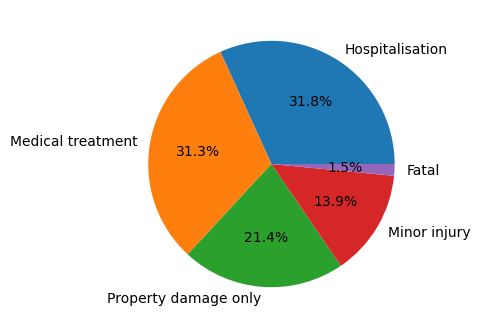

Crash_Severity
Hospitalisation         129821
Medical treatment       127856
Property damage only     87432
Minor injury             56900
Fatal                     6262
Name: Crash_Ref_Number, dtype: int64


In [36]:
# crash severity pie chart

crash_severity_pie = df.groupby('Crash_Severity')['Crash_Ref_Number'].count().sort_values(ascending=False)

plt.figure(figsize=(4,4))
plt.pie(crash_severity_pie.values, labels=crash_severity_pie.index, autopct='%1.1f%%')
plt.show()
print(crash_severity_pie)

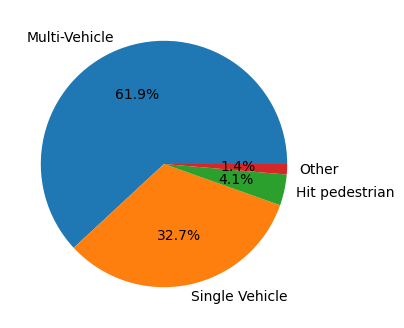

Crash_Type
Multi-Vehicle     252741
Single Vehicle    133375
Hit pedestrian     16568
Other               5587
Name: Crash_Ref_Number, dtype: int64


In [37]:
# crash type pie chart

crash_type_pie = df.groupby('Crash_Type')['Crash_Ref_Number'].count().sort_values(ascending=False)

plt.figure(figsize=(4,4))
plt.pie(crash_type_pie.values, labels=crash_type_pie.index, autopct='%1.1f%%')
plt.show()
print(crash_type_pie)

In [38]:
# Dynamic heatmap of the crashes

import folium
from folium.plugins import HeatMap

# --- 1. Prepare the Data ---

# Drop any rows where lat or lon is missing
df_clean = df.dropna(subset=['Crash_Latitude', 'Crash_Longitude'])

# --- 2. (IMPORTANT) Sample the Data ---

# Let's use a sample of 20,000 points for the heatmap.
if len(df_clean) > 20000:
    df_sample = df_clean.sample(n=20000)
else:
    df_sample = df_clean

# Create a list of [lat, lon] pairs, which is what HeatMap needs
locations = df_sample[['Crash_Latitude', 'Crash_Longitude']].values.tolist()

# --- 3. Create the Base Map ---

# Find the center of your data to center the map
center_lat = df_sample['Crash_Latitude'].mean()
center_lon = df_sample['Crash_Longitude'].mean()

# Create a map, centered on your data, with a good zoom level
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# --- 4. Add the Heatmap Layer ---

# Add the 'locations' data to the HeatMap plugin
HeatMap(locations).add_to(m)

m

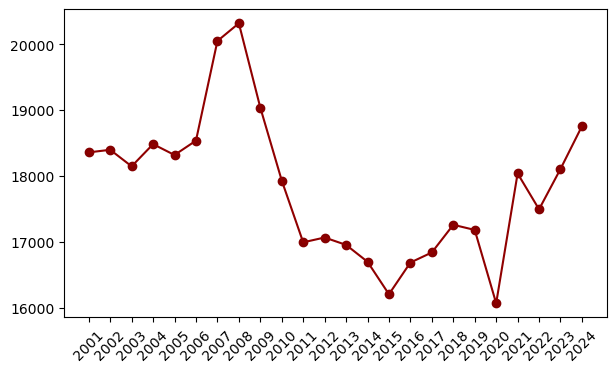

            Count_Casualty_Total
Crash_Year                      
2001                       18361
2002                       18400
2003                       18149
2004                       18486
2005                       18321
2006                       18539
2007                       20051
2008                       20320
2009                       19041
2010                       17934
2011                       16996
2012                       17069
2013                       16957
2014                       16701
2015                       16208
2016                       16689
2017                       16842
2018                       17262
2019                       17184
2020                       16071
2021                       18041
2022                       17497
2023                       18109
2024                       18758


In [39]:
# Sum of injured people (Count_Casualty_Total) vs. crash year:

pivot_table_injured_ppl = df.pivot_table(index='Crash_Year', values='Count_Casualty_Total', aggfunc='sum')

plt.figure(figsize=(7,4))
plt.scatter(x=pivot_table_injured_ppl.index,y=pivot_table_injured_ppl.values, color = '#850000')
plt.plot(pivot_table_injured_ppl.index, pivot_table_injured_ppl.values, linestyle='-', color='#900000')
plt.xticks(pivot_table_injured_ppl.index, rotation=45)
plt.show()
print(pivot_table_injured_ppl)

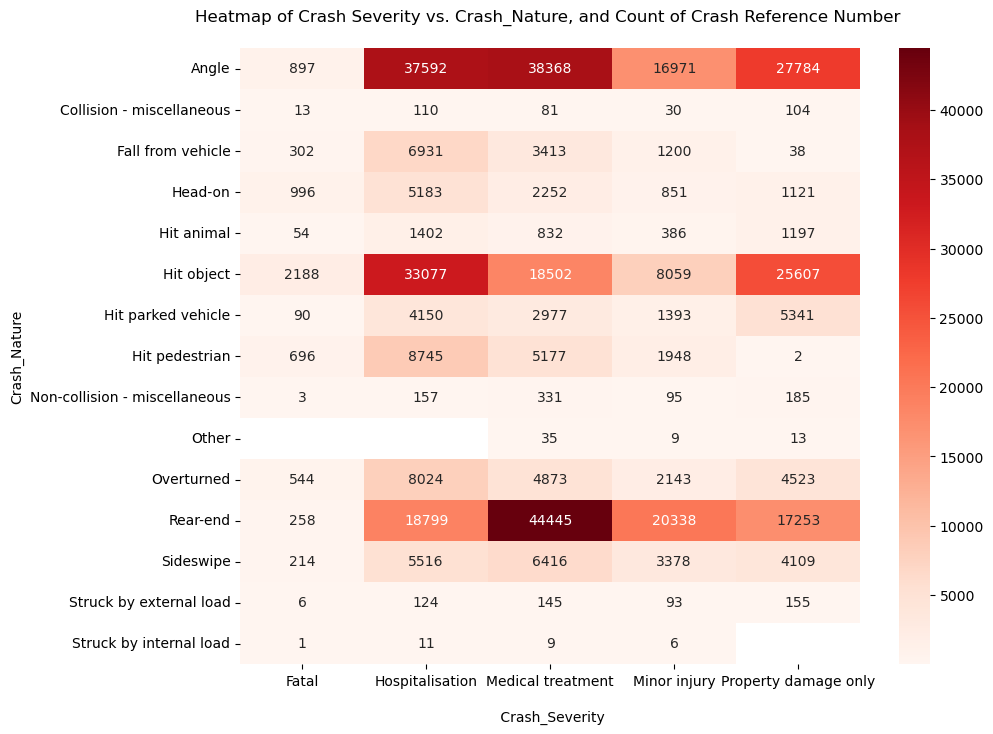

Crash_Severity
Fatal                     6262.0
Hospitalisation         129821.0
Medical treatment       127856.0
Minor injury             56900.0
Property damage only     87432.0
dtype: float64


In [40]:
crash_nature_severity = df.pivot_table(index='Crash_Nature', columns='Crash_Severity', values='Crash_Ref_Number', aggfunc='count')

# Heatmap

plt.figure(figsize=(10, 8))
cmap = sns.color_palette("Reds", as_cmap=True)
sns.heatmap(crash_nature_severity, cmap=cmap, annot=True, fmt='.0f', cbar=True, linecolor='black')
plt.title("Heatmap of Crash Severity vs. Crash_Nature, and Count of Crash Reference Number \n")
plt.xlabel("\n Crash_Severity")
plt.ylabel("Crash_Nature")
plt.show()

print(crash_nature_severity.sum())


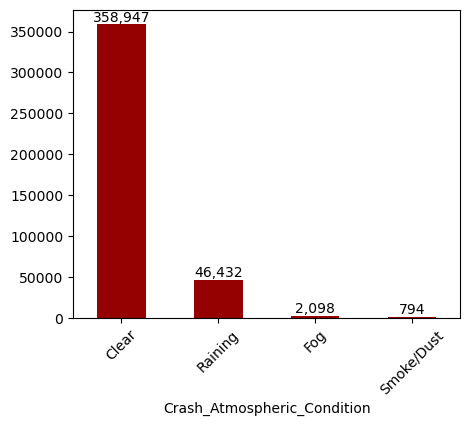

In [41]:
#### Crash_Atmospheric_Condition

plt.figure(figsize=(5,4))
Crash_Atmospheric_Condition = (df.groupby('Crash_Atmospheric_Condition')['Crash_Ref_Number'].count()).sort_values(ascending=False)
ax = Crash_Atmospheric_Condition.plot(kind = 'bar', color = '#950000')
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:,.0f}')
plt.xticks(rotation=45)

plt.show()

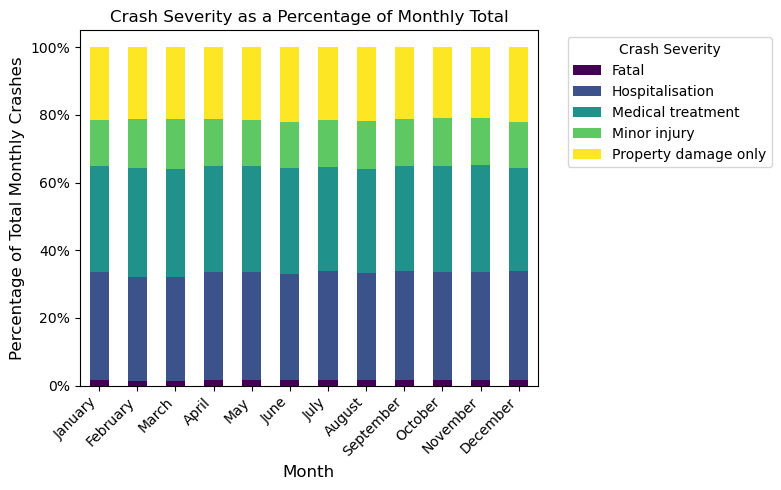

Details are showm below:


In [43]:
from matplotlib.ticker import PercentFormatter

# --- 1. Create the pivot table (same as yours) ---
pivot_table_monthly = df.pivot_table(index='Crash_Month', 
                                     columns='Crash_Severity', 
                                     values='Crash_Ref_Number', 
                                     aggfunc='count')

# --- 2. Fix Month Order (Proactive fix) ---
# Ensure the months are in chronological order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
pivot_table_monthly = pivot_table_monthly.reindex(month_order)

# --- 3. Convert to Percentages ---
# Sum each row (month) to get the total crashes for that month
month_totals = pivot_table_monthly.sum(axis=1)

# Divide each cell by its row total, then multiply by 100
df_percentage = pivot_table_monthly.div(month_totals, axis=0) * 100

# --- 4. Plot the Stacked Percentage Bar Chart ---
# Use the built-in pandas plotting, which makes stacking easy
ax = df_percentage.plot(
    kind='bar', 
    stacked=True, 
    figsize=(8, 5),
    colormap='viridis'  # You can pick any colormap
)

# --- 5. Set labels and legend ---
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Percentage of Total Monthly Crashes', fontsize=12)
ax.set_title('Crash Severity as a Percentage of Monthly Total', fontsize=12)

# Format the y-axis to show a '%' sign
ax.yaxis.set_major_formatter(PercentFormatter())

# Set legend title and move it outside the plot
ax.legend(title='Crash Severity', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ensure labels fit
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the bar chart
plt.show()

print('Details are showm below:')

In [44]:
round(df_percentage,2)

Crash_Severity,Fatal,Hospitalisation,Medical treatment,Minor injury,Property damage only
Crash_Month,,,,,
January,1.57,31.88,31.57,13.48,21.51
February,1.42,30.72,32.09,14.52,21.25
March,1.42,30.55,32.16,14.67,21.20
April,1.50,32.21,31.29,13.86,21.13
May,1.53,32.12,31.26,13.67,21.40
June,1.51,31.45,31.28,13.67,22.09
July,1.55,32.38,30.76,13.86,21.45
August,1.58,31.58,30.92,14.12,21.80
September,1.59,32.34,31.09,13.87,21.12


In [45]:
pivot_table_monthly

Crash_Severity,Fatal,Hospitalisation,Medical treatment,Minor injury,Property damage only
Crash_Month,,,,,
January,467,9499,9406,4016,6408
February,446,9671,10101,4569,6690
March,501,10758,11326,5168,7466
April,494,10612,10308,4567,6962
May,548,11469,11162,4882,7641
June,522,10907,10849,4741,7662
July,558,11640,11057,4984,7712
August,575,11484,11245,5136,7928
September,537,10922,10498,4683,7131


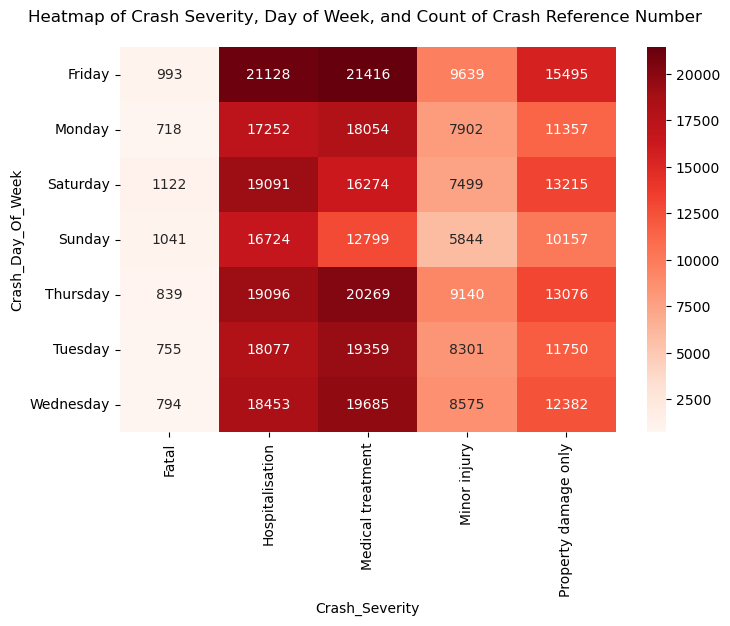

Overall crashes in weekdays:


,Crash_Ref_Number
Crash_Day_Of_Week,
Friday,68671
Monday,55283
Saturday,57201
Sunday,46565
Thursday,62420
Tuesday,58242
Wednesday,59889


In [46]:
# crash heatmap - weekday:

# Create a pivot table to arrange the data for the heatmap
pivot_table_weekday = df.pivot_table(index='Crash_Day_Of_Week', columns='Crash_Severity', values='Crash_Ref_Number', aggfunc='count')

# Create a heatmap using seaborn
plt.figure(figsize=(8, 5))

# Change the colormap to a dark red color scheme
cmap = sns.color_palette("Reds", as_cmap=True)

# Annotate with formatted integers
sns.heatmap(pivot_table_weekday, cmap=cmap, annot=True, fmt='.0f', cbar=True, linecolor='black')


# Set the title and labels
plt.title("Heatmap of Crash Severity, Day of Week, and Count of Crash Reference Number \n")
plt.xlabel("Crash_Severity")
plt.ylabel("Crash_Day_Of_Week")

plt.show()

pivot_table_weekday_Overall = df.pivot_table(index='Crash_Day_Of_Week', values='Crash_Ref_Number', aggfunc='count')
pivot_table_weekday
print('Overall crashes in weekdays:')
pivot_table_weekday_Overall

In [48]:
crash_street = df1.pivot_table(index = 'Crash_Street',values = 'Crash_Ref_Number', aggfunc='count')
crash_street.sort_values(by='Crash_Ref_Number', ascending=False)


,Crash_Ref_Number
Crash_Street,
Bruce Hwy,19718
Pacific Hwy,8257
Gold Coast Hwy,4837
Gateway Arterial Rd,3616
Warrego Hwy,2854
...,...
Jade Ct,1
Jaffa Rd,1
Jagera Pl,1


In [36]:
# Assuming df1 is already loaded and cleaned
df1['Crash_Street'] = df1['Crash_Street'].str.split().str[-1]

# --- Modified pivot_table call ---
crash_street_distribution = df1[df1['Crash_Year']>2010].pivot_table(index='Crash_Street', 
                                          columns='Crash_Severity', 
                                          values = 'Crash_Ref_Number', 
                                          aggfunc='count',
                                          fill_value=0,    # Good practice: replaces NaN with 0
                                          margins=True,      # <-- This adds the row/column totals
                                          margins_name='Total') # <-- This names the total row/column 'Total'

# --- How to sort by the new 'Total' column ---
# The table is now sorted by the 'Total' column, from highest to lowest
crash_street_distribution_sorted = crash_street_distribution.sort_values(by='Total', ascending=False)

# --- Display the results ---
# .drop('Total') removes the final "Total" summary row from the printout
# so you only see the sorted list of streets.
(crash_street_distribution_sorted.drop('Total').head(20))


Crash_Severity,Fatal,Hospitalisation,Medical treatment,Minor injury,Total
Crash_Street,,,,,
Rd,1726,35783,31602,10711,79822
St,313,18568,18037,6368,43286
Hwy,958,12162,8673,3132,24925
Dr,102,4301,3851,1544,9798
Ave,48,2475,2606,998,6127
Mwy,27,778,921,341,2067
Pde,12,631,732,282,1657
Tce,11,633,628,228,1500
Blvd,5,526,622,241,1394


In [49]:
df['Crash_Street'] = df['Crash_Street'].str.split().str[-1]

In [50]:
def map_crash_street (street):
    if street in ['Rd', 'St', 'Hwy', 'Dr', 'Ave']:
        return street
    else:
        return 'other'


df['Crash_Street'] = df['Crash_Street'].apply(map_crash_street)


In [51]:
df['Crash_Street'].unique()

array(['St', 'Rd', 'Hwy', 'other', 'Ave', 'Dr'], dtype=object)

##### It indicates that top 3 crash locations happened at Roads, Streets, Highways, respectively.

In [52]:
SL_CS_corr = df.pivot_table(index='Crash_Speed_Limit', columns='Crash_Severity', values='Crash_Ref_Number', aggfunc='count')
speed_limit_orders = ['0 - 50 km/h', '60 km/h', '70 km/h', '80 - 90 km/h', '100 - 110 km/h']
SL_CS_corr = SL_CS_corr.reindex(speed_limit_orders)

SL_CS_corr.style.background_gradient(
        cmap='Reds',  # This colormap goes from light/white to red
        axis=None     # 'axis=None' applies the gradient to the *entire* matrix, not just by column
    ).format('{:.2f}')

Crash_Severity,Fatal,Hospitalisation,Medical treatment,Minor injury,Property damage only
Crash_Speed_Limit,,,,,
0 - 50 km/h,581.00,22227.00,22043.00,10384.00,13911.00
60 km/h,1552.00,58906.00,68836.00,31187.00,45721.00
70 km/h,330.00,8320.00,8707.00,3615.00,4944.00
80 - 90 km/h,1008.00,14135.00,10550.00,4295.00,7731.00
100 - 110 km/h,2791.00,26233.00,17720.00,7419.00,15125.00


----
#### we performed EDA and explored the data by visualizing differernt features. Now it's ready to implement Machine Learning Model:
----

## if you like the analysis please upvote :)